In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Data Exploration

The data used in this project is taken from kaggle(https://www.kaggle.com/miquar/explore-flights-csv-airports-csv-airlines-csv/data). It consists of the information about different delayed, cancelled as well as diverted flights in 2015.Using this data, I will predict if the flight will have a departure in its delay.

In [3]:
#load the csv file
#use only the first 100000 rows of data
df_use = pd.read_csv('flights.csv')
# df = df_use.sample(n=100000).copy()
df = df_use
del df_use

C:\Users\Atul\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The most important column here is DEPARTURE_DELAY, which tells us if a flight was delayed or not. 

In [4]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# count the number of rows for each type
df.groupby('DEPARTURE_DELAY').size()

DEPARTURE_DELAY
-82.0        1
-68.0        1
-61.0        1
-56.0        1
-55.0        1
-52.0        1
-48.0        2
-47.0        1
-46.0        1
-45.0        4
-44.0        1
-43.0        2
-42.0        5
-41.0        7
-40.0       12
-39.0       11
-38.0       12
-37.0       15
-36.0       17
-35.0       25
-34.0       23
-33.0       25
-32.0       26
-31.0       32
-30.0       57
-29.0       55
-28.0       94
-27.0      106
-26.0      173
-25.0      226
          ... 
 1450.0      1
 1457.0      2
 1458.0      1
 1461.0      1
 1471.0      1
 1475.0      1
 1480.0      1
 1492.0      1
 1496.0      1
 1515.0      1
 1521.0      1
 1522.0      1
 1523.0      1
 1536.0      1
 1542.0      1
 1544.0      1
 1551.0      1
 1557.0      1
 1573.0      1
 1576.0      1
 1587.0      1
 1589.0      1
 1604.0      1
 1609.0      1
 1625.0      1
 1631.0      1
 1649.0      1
 1670.0      1
 1878.0      1
 1988.0      1
Length: 1217, dtype: int64

(-20, 20)

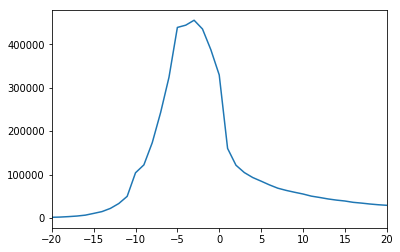

In [9]:
plt.plot(df.groupby('DEPARTURE_DELAY').size())
plt.xlim(-20,20)

Another column that is important is CANCELLED, which tells us whether the flight was cancelled or not.

In [10]:
df.groupby('CANCELLED').size()

CANCELLED
0    5729195
1      89884
dtype: int64

If we look at the IDs_mapping.csv we can see that 1 is related to cancelled flight. We should remove these samples from the predictive model.

In [35]:
df_copy = df
df = df.loc[~df.CANCELLED.isin([1])]

Now let's define an output variable for our binary classification. Here we will try to predict if a flight is going to have a departure in its delay or not.

In [36]:
df['OUTPUT_LABEL'] = (df.DEPARTURE_DELAY >= 0).astype('int')

C:\Users\Atul\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
df.groupby('OUTPUT_LABEL').size()

OUTPUT_LABEL
0    3276871
1    2452324
dtype: int64

# Feature Engineering

In [38]:
#load the airports dataset
df_airports = pd.read_csv('airports.csv')
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [39]:
#change the unknown airport numbers to other (reduces the dimensionality a lot)
df.loc[~df.ORIGIN_AIRPORT.isin(df_airports.IATA_CODE.values),'ORIGIN_AIRPORT'] = 'OTHER'
df.loc[~df.DESTINATION_AIRPORT.isin(df_airports.IATA_CODE.values),'DESTINATION_AIRPORT'] = 'OTHER'

C:\Users\Atul\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Numerical Features

 The columns that are numerical that we will use are shown below

In [40]:
df[['OUTPUT_LABEL','DEPARTURE_DELAY','SCHEDULED_DEPARTURE','DEPARTURE_TIME','SCHEDULED_ARRIVAL','ARRIVAL_TIME','ARRIVAL_DELAY']].head()

,OUTPUT_LABEL,DEPARTURE_DELAY,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,0,-11.0,5,2354.0,430,408.0,-22.0
1,0,-8.0,10,2.0,750,741.0,-9.0
2,0,-2.0,20,18.0,806,811.0,5.0
3,0,-5.0,20,15.0,805,756.0,-9.0
4,0,-1.0,25,24.0,320,259.0,-21.0


In [41]:
cols_num = ['SCHEDULED_DEPARTURE','SCHEDULED_TIME','DISTANCE','SCHEDULED_ARRIVAL','DAY_OF_WEEK']
cols_num

['SCHEDULED_DEPARTURE',
 'SCHEDULED_TIME',
 'DISTANCE',
 'SCHEDULED_ARRIVAL',
 'DAY_OF_WEEK']

Let's check if there are any missing values in the numerical data.

In [42]:
df[cols_num].isnull().sum()

SCHEDULED_DEPARTURE    0
SCHEDULED_TIME         1
DISTANCE               0
SCHEDULED_ARRIVAL      0
DAY_OF_WEEK            0
dtype: int64

In [43]:
print(df.shape)
df = df[df[cols_num]["SCHEDULED_TIME"].isnull()==False]
print(df.shape)

(5729195, 32)
(5729194, 32)


## Categorical Features

The first set of categorical data we will deal with are these columns:

In [44]:
cols_cat = ['AIRLINE','ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
cols_cat

['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

Check number of unique options

In [45]:
df[cols_cat].nunique()

AIRLINE                 14
ORIGIN_AIRPORT         323
DESTINATION_AIRPORT    323
dtype: int64

Let's check if there are any missing data

In [46]:
df[cols_cat].isnull().sum()

AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
dtype: int64

In one-hot encoding, we create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column AIRLINE, we would create new columns ('AIRLINE_AS','AIRLINE_B6', etc). If the airline is AS, the flight gets a 1 under 'AIRLINE_AS' and 0 under the rest of the AIRLINE columns. To create these one-hot encoding columns, we can use the get_dummies function. I used the prefix option so we can trace back to the original column.

In [47]:
pd.get_dummies(df['AIRLINE'],prefix = 'AIRLINE').head()

,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
pd.get_dummies(df['AIRLINE'],prefix = 'AIRLINE', drop_first = True).head()

,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0


Now it would be annoying to have to use get_dummies for each categorical column. Luckily, we can send all the columns at once into the get_dummies function and use the column name as the prefix.

In [49]:
pd.get_dummies(df[cols_cat],drop_first = True).head()

,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,...,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df_cat = pd.get_dummies(df[cols_cat],drop_first = True)

In [51]:
df_cat.head()

,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,...,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df = pd.concat([df,df_cat], axis = 1)

In [53]:
cols_all_cat = list(df_cat.columns)
print('number of categorical:',len(cols_all_cat))

number of categorical: 657


## Engineering Features Summary

Let's make a new dataframe that only has the columns of interest

In [60]:
df_all
df = df.sample(n=500000).copy()

In [61]:
cols_input = cols_num + cols_all_cat
df_data = df[cols_input + ['OUTPUT_LABEL']]
df_data.head()

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DAY_OF_WEEK,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,...,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM,OUTPUT_LABEL
3042290,951,98.0,483,1029,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3466424,1146,104.0,550,1330,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5310111,951,62.0,214,1053,7,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
350464,1935,60.0,95,2035,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1663171,535,141.0,802,756,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that we can measure how well our model would do on unseen data. We split into three parts:

- Training samples: these samples are used to train the model
- Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model
- Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model

In this project, we will split into 70% train, 15% validation, 15% test.

The first thing I like to do is to shuffle the samples using sample in case there was some order (e.g. all positive samples on top). Here n is the number.

In [62]:
#shuffle the samples
df_data = df_data.sample(n = len(df_data))
df_data = df_data.reset_index(drop = True)

We can use sample again to extract 30% (using frac) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it.

In [63]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction.

In [64]:
#now split into test and validation using 50% fraction
df_test = df_valid_test.sample(frac = 0.5)
df_valid = df_valid_test.drop(df_test.index)

Note that .drop just drops the rows from df_test to get the rows that were not part of the sample. We can use this same idea to get the training data.

In [65]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

At this point, let's check what percent of our groups have a departure delay. This is known as prevalence. Ideally, all the groups would have similar prevalance.

In [66]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [67]:
print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.426


In [68]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 75000):0.428
Valid prevalence(n = 75000):0.424
Train all prevalence(n = 350000):0.426


The prevalence is about the same for each group. Now let's save our data into separate csv files. Note that index = False just drops the index from the csv.

In [69]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

# Prepare data

 Here, we will create a balanced training data set that has 50% positive and 50% negative samples each. (The code has been commented for now and no balancing is being done)

In [70]:
# # split the training data into positive and negative
# rows_pos = df_train_all.OUTPUT_LABEL == 1
# df_train_pos = df_train_all.loc[rows_pos]
# df_train_neg = df_train_all.loc[~rows_pos]

# # merge the balanced data
# df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))],axis = 0)

# shuffle the order of training samples 
# df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)
df_train = df_train_all

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 350000):0.426


Now we have a balanced training set. Let's extract the column names for the inputs

In [71]:
col2use = [c for c in list(df_train_all.columns) if c != 'OUTPUT_LABEL']
print(len(col2use))

662


Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [72]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (350000, 662)
Training shapes: (350000, 662) (350000,)
Validation shapes: (75000, 662) (75000,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler which removes the mean and scales to unit variance. Here I will create a scaler using all the training data.

In [73]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler(copy=True, with_mean=True, with_std=True)

Again, we will need this scaler for the test data, so let's save it using a package called pickle.

In [74]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

Load it back:

In [75]:
scaler = pickle.load(open(scalerfile, 'rb'))

Now we can transform our data matrices

In [76]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Tour of machine learning algorithms in sklearn

We will now explore a few different machine learning algorithms. We will mostly use the default parameters.

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

For this analysis, let's set our threshold at 0.5.

In [78]:
thresh = 0.5

## Logistic regression

This is the standard logistic regression model

In [79]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.661
accuracy:0.633
recall:0.426
precision:0.597
specificity:0.786
prevalence:0.426
 
Validation:
AUC:0.657
accuracy:0.631
recall:0.421
precision:0.591
specificity:0.786
prevalence:0.424
 


## Stochastic Gradient Descent

When you have a lot of data logistic regression may take a long time to compute. There is an alternative approach called stochastic gradient descent that works similarly to logistic regression but doesn't use all the data at each iteration.

In [81]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1)
sgdc.fit(X_train_tf, y_train)

C:\Users\Atul\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [82]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.657
accuracy:0.629
recall:0.363
precision:0.608
specificity:0.826
prevalence:0.426
 
Validation:
AUC:0.654
accuracy:0.630
recall:0.361
precision:0.606
specificity:0.828
prevalence:0.424
 


## Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB(priors=None)

In [84]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.533
accuracy:0.474
recall:0.917
precision:0.444
specificity:0.145
prevalence:0.426
 
Validation:
AUC:0.530
accuracy:0.469
recall:0.912
precision:0.439
specificity:0.143
prevalence:0.424
 


## Decision Tree Classifier

In [85]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [86]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.671
accuracy:0.636
recall:0.423
precision:0.606
specificity:0.795
prevalence:0.426
 
Validation:
AUC:0.658
accuracy:0.631
recall:0.412
precision:0.592
specificity:0.791
prevalence:0.424
 


## Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 10)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.658
accuracy:0.623
recall:0.239
precision:0.662
specificity:0.909
prevalence:0.426
 
Validation:
AUC:0.649
accuracy:0.622
recall:0.232
precision:0.650
specificity:0.908
prevalence:0.424
 


## Gradient Boosting Classifier 

In [91]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100,
     max_depth=3, learning_rate=1.0)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [92]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.683
accuracy:0.645
recall:0.446
precision:0.616
specificity:0.794
prevalence:0.426
 
Validation:
AUC:0.672
accuracy:0.641
recall:0.439
precision:0.604
specificity:0.789
prevalence:0.424
 


# Analyze Results

  Let's make a dataframe with these results and plot the outcomes using a package called seaborn.

In [93]:
df_results = pd.DataFrame({'classifier':['LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*6,
                          'auc':[lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [94]:
import seaborn as sns
sns.set(style="darkgrid")

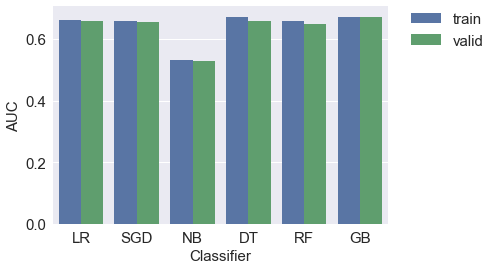

In [95]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15) 
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

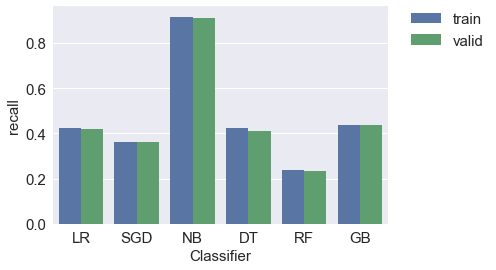

In [96]:
ax = sns.barplot(x="classifier", y="recall", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

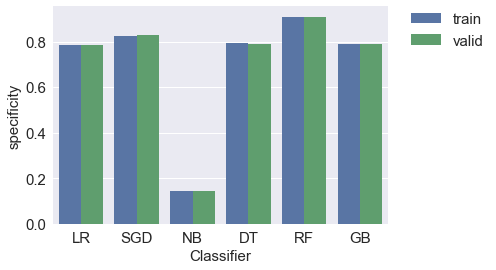

In [97]:
ax = sns.barplot(x="classifier", y="specificity", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('specificity', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

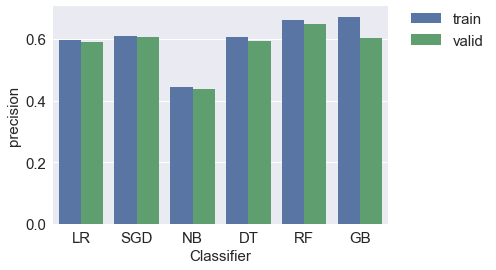

In [98]:
ax = sns.barplot(x="classifier", y="precision", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('precision', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

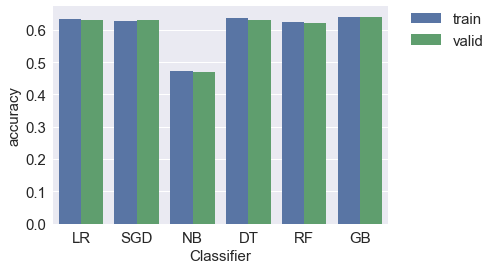

In [99]:
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

Now, we will plot the learning curves : 

In [100]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("AUC")
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
                                                        scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Plot the learning curves

In [101]:
from sklearn.ensemble import RandomForestClassifier

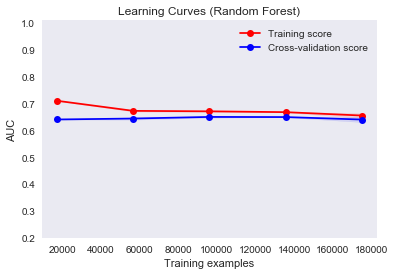

In [102]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=2, test_size=0.5)
estimator = RandomForestClassifier(max_depth = 10)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

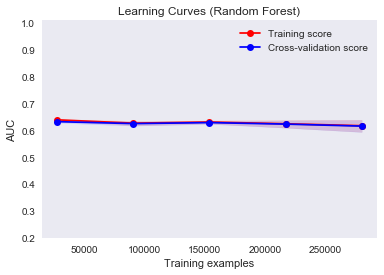

In [103]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2)
estimator = RandomForestClassifier(max_depth = 3)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the first case, we see that there is a large difference between the training and validation scores. This is known as high variance and is a sign of overfitting. In the second case, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting.

<font size=5><b>Feature Importance </b></font> 

One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests. Let's get the feature importance for a few models and then we can discuss what we see.

## logistic regression

Logistic regression is a very interpretable model because the coefficient for each variable shows how important that variable is for the prediction.We need to have normalized data so the coefficients are comparable between variables.

In [104]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can extract the coefficients using coef_ and store in a new dataframe (sorted by importance)

In [105]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [106]:
feature_importances.head()

,importance
AIRLINE_WN,0.374266
SCHEDULED_DEPARTURE,0.282730
AIRLINE_UA,0.200689
SCHEDULED_TIME,0.183782
SCHEDULED_ARRIVAL,0.126193


For logistic regression, the variables with highest positive coefficients are predictive of delay in flight departures and the variables with highest negative coefficients are predictive of no delay in the flight departures. We can plot the top 50 for each direction below.

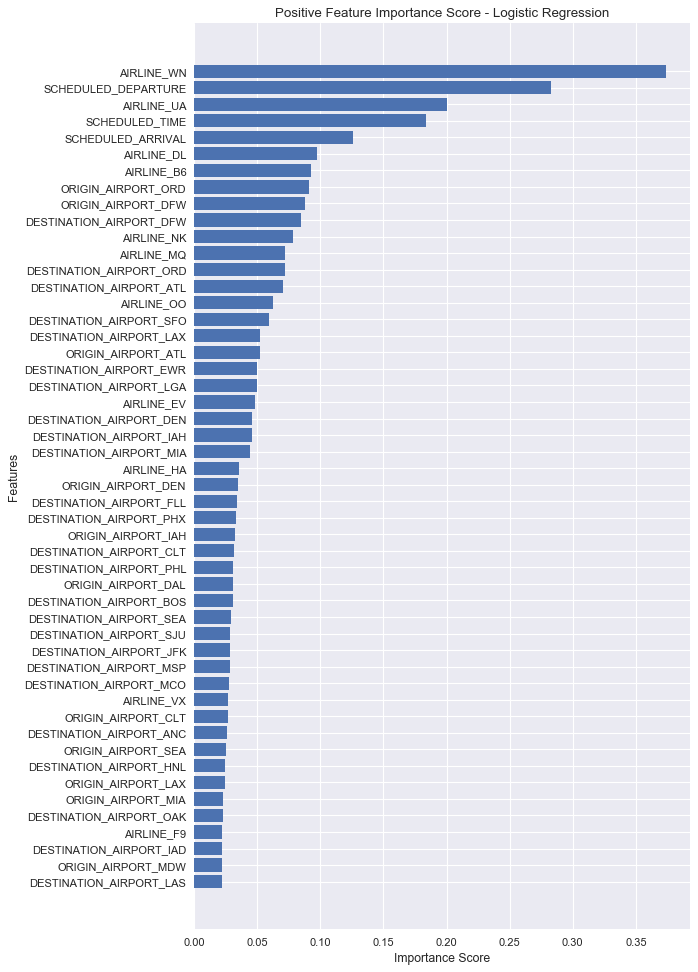

In [107]:
num = 50
ylocs = np.arange(num)

# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

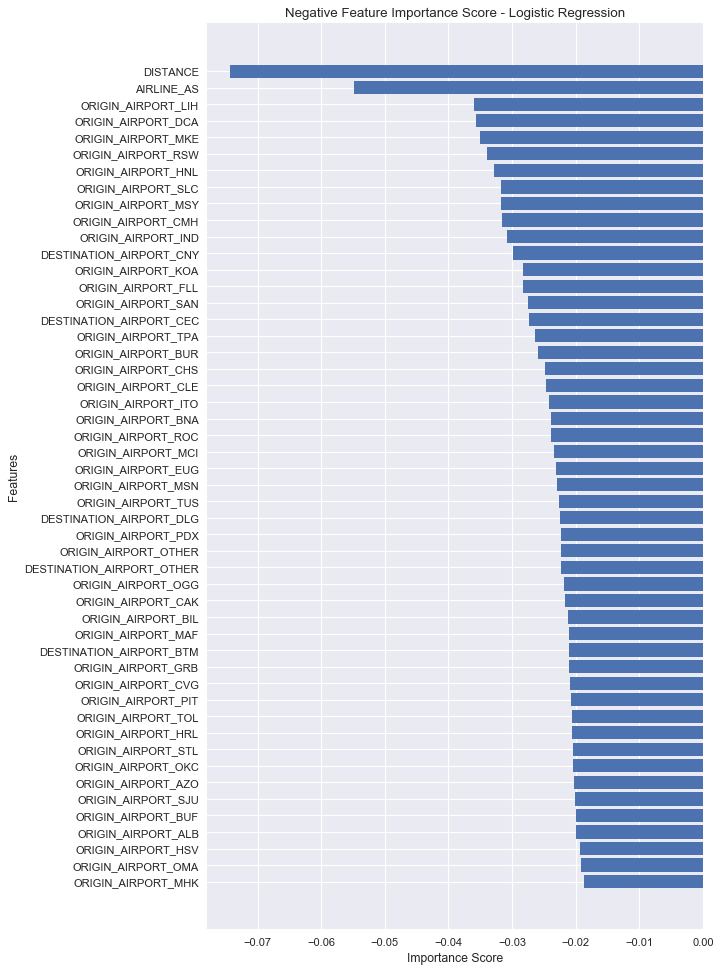

In [108]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

# SAVE YOUR BEST CLASSIFIER

You won't want to train your best classifier every time you want to run new predictions. Therefore, we need to save the classifier. We will use the package pickle. Here we will chose the logistic regression classifier since it has the closest Training / Validation scores.

In [109]:
pickle.dump(lr, open('best_classifier.pkl', 'wb'),protocol = 4)

Now let's evaluate our best model on our test data.

In [110]:
import pickle
# load the model
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [111]:
df_test= pd.read_csv('df_test.csv')

#create X and Y matrix
X_test = df_test[col2use].values
y_test = df_test['OUTPUT_LABEL'].values

#transform our data matrices
X_test_tf = scaler.transform(X_test)

# Predictions

In [112]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

# Evaluate the performance

In [113]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [114]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.661
accuracy:0.633
recall:0.426
precision:0.597
specificity:0.786
prevalence:0.426
 
Validation:
AUC:0.657
accuracy:0.631
recall:0.421
precision:0.591
specificity:0.786
prevalence:0.424
 
Test:
AUC:0.657
accuracy:0.630
recall:0.427
precision:0.594
specificity:0.782
prevalence:0.428
 


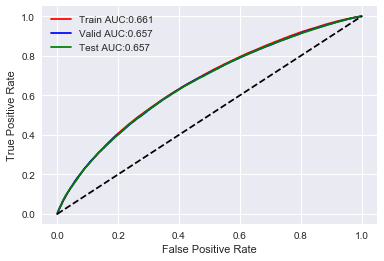

In [115]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The model was able to catch 63% of the flight delays.